In [295]:
import numpy as np, matplotlib.pyplot as plt, os
from scipy.ndimage import gaussian_filter1d
from typing import Callable
from numpy.typing import NDArray

In [303]:
# ----- INITIALISE -----
R_MAX = 1
R_MIN = 0.1
EPS = 1e-12
NUM_BINS_SMAK = 400
SQRT_R_MAX = np.sqrt(R_MAX)
SQRT_R_MIN = np.sqrt(R_MIN)
U_MAX = 1/SQRT_R_MIN
OUTPUT_DIR_NAME = "outputs/"

if not os.path.exists(OUTPUT_DIR_NAME):
    raise Exception("directory not found")

In [308]:
# ----- FUNCTION DEFINITIONS -----

def get_intens(
        r: np.ndarray[np.float64], 
        theta: np.ndarray[np.float64],
        a: float = 1.5
) -> np.ndarray[np.float64]:
    """
    Returns the brightness on the accretion disk at a given radius
    according to the inverse power law r^(-a)
    """
    return r**(-a)

def get_grids(
    intens_func: Callable[[float, float, float], float] = get_intens,   # function(r, theta, a)
    a: float = 1.5,
    num_radial: int = 400,
    num_theta: int = 8192,
    radial_spacing: str = "log",   # "log" or "linear"
    other_intens_params: list | None = None
):
    """
    Returns a tuple of ndarrays: `(r_grid, theta_grid, intens_grid, vel_grid, area_flux_grid)`
    by sampling the disk in polar coordinates and multiplying the intensities by the area of
    each coordinate.
    """
    # --- radial edges & centres ---
    if radial_spacing == "log":
        r_edges = np.geomspace(R_MIN, R_MAX, num_radial + 1)    # num_radial points spaced logarithmically from R_MIN - R_MAX
        r_centres = get_bin_centres(r_edges, is_log=True)
    elif radial_spacing == "linear":
        r_edges = np.linspace(R_MIN, R_MAX, num_radial + 1)     # num_radial points spaced linearly from R_MIN - R_MAX
        r_centres = get_bin_centres(r_edges)
    else:
        raise Exception("invalid radial_spacing argument")
    # array of distances between r_edges of length num_radial
    dr = r_edges[1:] - r_edges[:-1]

    # theta edges & centres
    theta_edges = np.linspace(0.0, 2.0 * np.pi, num_theta + 1)
    theta_centres = get_bin_centres(theta_edges)
    dtheta = theta_edges[1] - theta_edges[0] # all equally spaced so 1st - 0th = scalar is fine

    # create 2D grid (theta x r)
    r_grid, theta_grid = np.meshgrid(r_centres, theta_centres)

    # area weight for each cell: r * dr * dtheta (from Jacobian)
    area_weights = r_grid * dr * dtheta

    # evaluate intensity and velocity on the grid
    if other_intens_params is None:
        intens_grid = intens_func(r_grid, theta_grid, a)
    else:
        intens_grid = intens_func(r_grid, theta_grid, a, other_intens_params)
    area_flux_grid = intens_grid * area_weights
    vel_grid = np.cos(theta_grid) / np.sqrt(r_grid)

    return (r_grid, theta_grid, intens_grid, vel_grid, area_flux_grid)

def plot_polar_profile(
    r_grid: np.ndarray[np.float64],
    theta_grid: np.ndarray[np.float64],
    values: np.ndarray[np.float64],
    num_contours: int = 50,
    colourmap: str = "inferno",
    title: str = "Profile",
    colour_bar_name: str = "Value",
    figure_size: tuple[int, int] = (6, 6),
    vmin: float = None, vmax: float = None,
    colour_contrast_style: str = "90",
        # "symmetric" to set symmetric color limits around 0 (for signed fields)
        # "nonneg" to force vmin=0 and vmax=max (for non-negative fields)
    save_info: bool = False,
    fname: str | None = None
) -> None:
    """
    Plots a 2D numpy array of polar values (r, theta) on a disk with a colour bar.
    """
    # Auto colour scaling helpers
    if colour_contrast_style == "symmetric":    # colour bar ranges from - max val to + max val 
        vmax_auto = np.nanmax(np.abs(values))
        vmin_plot = -vmax_auto
        vmax_plot =  vmax_auto
    elif colour_contrast_style == "nonneg":     # colour bar ranges from 0 to max val
        vmin_plot = 0.0
        vmax_plot = np.nanmax(values)
    elif colour_contrast_style == "90":     # colour bar ranges from 0 to max val
        vmin_plot = np.percentile(values, 10)
        vmax_plot = np.percentile(values, 90)
    elif (
        colour_contrast_style == "custom" and   # colour bar ranges from vmin to vmax
        vmin is not None and vmax is not None
    ):
        vmin_plot = vmin
        vmax_plot = vmax
    else:
        raise Exception("invalid colour contrast arguments")


    fig, ax = plt.subplots(figsize=figure_size, subplot_kw=dict(projection="polar"))
    contour = ax.contourf(
        theta_grid, r_grid, values,
        levels=num_contours,
        # vmin=vmin_plot, #TODO: fix this
        # vmax=vmax_plot,
        cmap=colourmap
    )
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label(colour_bar_name)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if save_info:
        if fname is None:
            raise Exception("invalid intens_func_name")
        plt.savefig(fname)
    plt.show()


def get_hist_vals(
    vel_grid: np.ndarray[np.float64],
    area_flux_grid: np.ndarray[np.float64], *,
    num_bins: int = 1200,
    normalise: bool = True,
    smooth_sigma: float | None = None
) -> tuple[np.ndarray[np.float64], np.ndarray[np.float64]]:
    """
    Flattens and places valid `area_flux_grid` values into `num_bins` bins
    using numpy\'s `histogram` function. Returns the tuple
    `(u_bin_centres, hist_brightness_vals)`.
    """
    u_flat = vel_grid.ravel()
    a_flux_flat = area_flux_grid.ravel()

    # remove NaNs/Infs and (unnecessary) zero-weight samples
    finite_mask = np.isfinite(u_flat) & np.isfinite(a_flux_flat) & (a_flux_flat > 0)
    u_flat = u_flat[finite_mask]
    a_flux_flat = a_flux_flat[finite_mask]

    # --- histogram into uniform velocity bins that scale with R_MIN ---
    u_bin_edges = np.linspace(-U_MAX, U_MAX, num_bins + 1)
    hist_brightness_vals, _ = np.histogram(u_flat, bins=u_bin_edges, weights=a_flux_flat) #returns bin edges as well but that's not needed
    u_bin_centres = get_bin_centres(u_bin_edges)

    if normalise and np.max(hist_brightness_vals) > 0:
        hist_brightness_vals /= np.max(hist_brightness_vals)

    if smooth_sigma is not None and smooth_sigma > 0:
        hist_brightness_vals = gaussian_filter1d(hist_brightness_vals, sigma=smooth_sigma)

    return u_bin_centres, hist_brightness_vals

def plot_spectrum_list(
    a_vals: (
        np.ndarray[np.float64] | float
    ) = np.arange(0, 2.51, 0.5),
    intens_funcs: (
        list[Callable[[float, float, float], float]] | 
        Callable[[float, float, float], float]
    ) = get_intens,
    other_intens_params: list | None = None,
    plot_smak: bool = False,
    sigma: float = None, *,
    xlim: tuple[float, float] = (-5, 5),
    xlabel="Relative Speed",
    ylabel="Brightness",
    title="Light Spectrum",
    figure_size: tuple[float, float] = (8, 5),
    grid_alpha: float = 0.3,
    save_info: bool = False
) -> str | None:
    """
    Plots the model intensity over a range of u values (speeds/wavelengths) for a disk with
    brightness decsribed by the functions in `intens_funcs` over a range of `a_vals`. Optionally
    plots Smak analytical solitions on top if `plot_smak` is `True`.
    """
#region Exception handling
    if sigma is not None and sigma <= 0:
        raise Exception("Invalid sigma argument")
    if a_vals is None:
        raise Exception("Invalid a_vals argument")
    if intens_funcs is None:
        raise Exception("Invalid intens_funcs argument")

    only_one_a = False
    if isinstance(a_vals, (int, float)):
        only_one_a = True
    elif not isinstance(a_vals, np.ndarray) or len(a_vals) == 0:
        raise Exception("Invalid a_vals argument")
    
    only_one_func = False
    if isinstance(intens_funcs, Callable):
        only_one_func = True
    elif not isinstance(intens_funcs, list) or len(intens_funcs) == 0:
        raise Exception("Invalid only_one_func argument")
    
    num_options = 1
    if only_one_a:
        if not only_one_func:
            num_options = len(intens_funcs)
        a_vals = np.array([a_vals] * num_options)
    if only_one_func:
        if not only_one_a:
            num_options = len(a_vals)
        intens_funcs = [intens_funcs] * num_options

    if len(a_vals) != len(intens_funcs):
        raise Exception("only_one_func should have same length as a_vals")
#endregion

    plt.figure(figsize=figure_size)

    for i in range(len(a_vals)):
        cur_a = a_vals[i]
        cur_func = intens_funcs[i]
        # radial sampling
        _, _, _, vel_grid, area_flux_grid = get_grids(
            intens_func=cur_func, a=cur_a,
            other_intens_params=other_intens_params
        )
        u_bin_centres, hist_brightness_vals = get_hist_vals(vel_grid, area_flux_grid)


        if sigma is not None:
            hist_brightness_vals = gaussian_filter1d(hist_brightness_vals, sigma=sigma)

        model_label = f"a = {cur_a}, func_ID = {i}"

        if plot_smak:
            smak_u_vals = np.linspace(-U_MAX, U_MAX, NUM_BINS_SMAK)
            smak_brightness = smak_F(smak_u_vals, cur_a)
            if sigma is not None:
                smak_brightness = gaussian_filter1d(smak_brightness, sigma=sigma)
            
            model_label = f"Model (a={cur_a})"
            smak_label = f"Smak (a={cur_a})"

            plt.plot(
                smak_u_vals, smak_brightness,
                linestyle = "--", label=smak_label
            )

        plt.plot(
            u_bin_centres, hist_brightness_vals,
            linestyle = '-', label = model_label
        )

    plt.xlabel(f"{xlabel}")
    plt.ylabel(ylabel)
    smoothtag = f" (Gaussian smoothed, sigma={sigma:g})" if (sigma is not None and sigma > 0) else ""
    plt.title(title + smoothtag)
    plt.grid(True, alpha=grid_alpha)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.legend()
    plt.tight_layout()
    if save_info:
        gen_fname = OUTPUT_DIR_NAME
        for i in range(len(a_vals)):
            gen_fname += intens_funcs[i].__name__ + f"_a_{a_vals[i]:.2f}__"
        if sigma is not None:
            gen_fname += f"_sigma_{sigma}__"
        if other_intens_params is not None:
            for param in other_intens_params:
                gen_fname += f"{param:.2f}_"
        gen_fname = gen_fname.strip("_")
        plt.savefig(f"{gen_fname}_spectrum.png")
    plt.show()
    if save_info:
        return gen_fname + ".png"


# ----- SMAK FUNCTIONS -----

def smak_F(u_vals: np.ndarray[np.float64], a: float) -> np.ndarray[np.float64]:
    """
    Returns a numpy array of intensity values F(u) associated with the array
    of `u_vals` given, according to Smak\'s analytical solution.
    """
    intensities = np.full_like(u_vals, np.nan, float)   # make array of NaNs

    exp = 2*a - 5

    for j, u in enumerate(u_vals):
        # guard the singular prefactor at u=0 if exponent < 0
        if abs(u) < EPS and exp < 0:
            intensities[j] = np.nan
            continue

        x_z = np.clip(u, -1.0, 1.0)
        x_1 = np.clip(u * SQRT_R_MIN, -1.0, 1.0)

        upper = smak_I(a, x_z)
        lower = smak_I(a, x_1)
        diff  = upper - lower

        intensities[j] = (u**exp) * diff

    # normalise robustly (optional)
    finite = np.isfinite(intensities)
    norm_intens = intensities
    if finite.any(): # check if any intensities are finite
        amp = np.nanmax(np.abs(intensities))
        if (np.isfinite(amp) and amp > 0):
            norm_intens = intensities / amp

    return norm_intens

def smak_I(a: float, x: float) -> float:
    """
    Helper function for :func:`smak_F`.
    """
    result = np.nan
    if abs(x) <= 1.0:
        s = np.sqrt(1.0 - x**2)
        if a == 0.0:
            result = -((x**3)/4.0 + (3.0*x)/8.0) * s + (3.0/8.0) * np.arcsin(x)
        elif a == 0.5:
            result = (1.0/3.0) * (s**3) - s
        elif a == 1.0:
            result = -(x/2.0) * s + 0.5 * np.arcsin(x)
        elif a == 1.5:
            result = -s
        elif a == 2.0:
            result = np.arcsin(x)
        elif a == 2.5:
            result = np.log(abs((1.0 - s) / x)) if abs(x) > EPS else np.nan
        else:
            raise NotImplementedError("Only a ∈ {0,0.5,1,1.5,2,2.5} supported.")
    return result


# ----- HELPER FUNCTIONS -----

def get_bin_centres(edges: np.ndarray, is_log: bool = False) -> np.ndarray:
    if is_log:
        # geometric-centre for each bin in log space
        return np.sqrt(edges[:-1] * edges[1:])
    # bin centres for linearly spaced edges
    return (edges[:-1] + edges[1:]) / 2

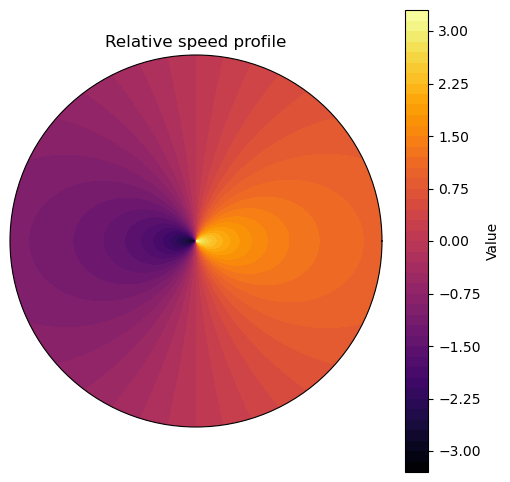

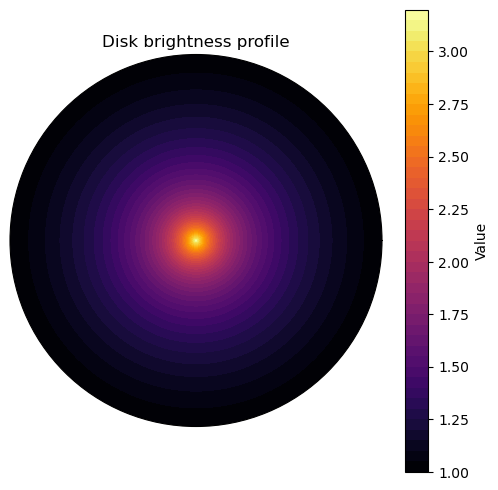

In [282]:
# ----- TESTING -----

r_vals, theta_vals, intens_vals, vel_vals, area_flux_vals = get_grids(a=0.5)


plot_polar_profile(r_vals, theta_vals, vel_vals, title="Relative speed profile")
plot_polar_profile(r_vals, theta_vals, intens_vals, title="Disk brightness profile")

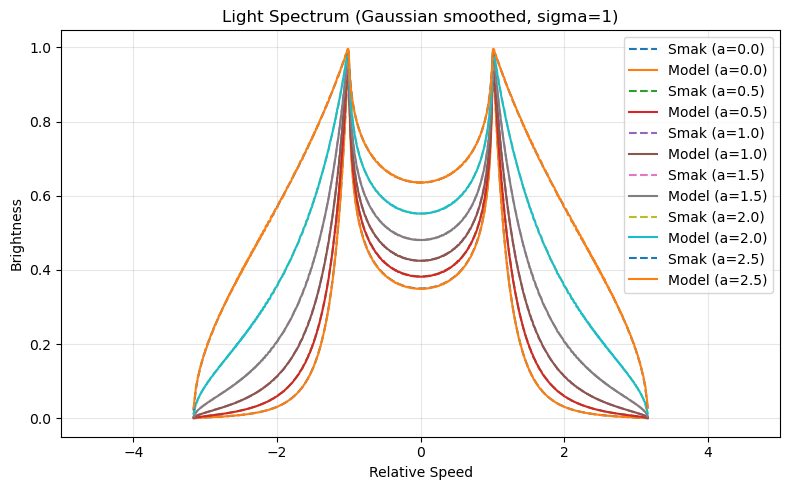

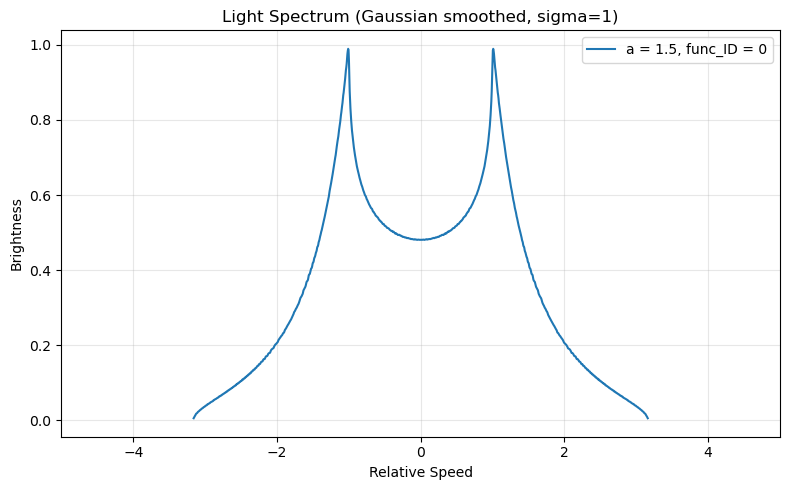

In [283]:
# ----- TESTING -----

sigma = 1
plot_smak = R_MAX == 1
title = "Light Spectrum"
title += " (raw)" if sigma is None else ""

plot_spectrum_list(title=title, plot_smak=plot_smak, sigma=sigma)
plot_spectrum_list(title=title, a_vals=1.5, sigma=sigma)

In [284]:
def add_ring(
    base: np.ndarray,
    max_intens_frac: float,
    r: np.ndarray,
    ring_r: float,
    ring_width: float,
    beta: float = 1.5
) -> np.ndarray:
    dist_to_ring = np.abs(r - ring_r)
    not_in_ring = dist_to_ring > ring_width / 2
    max_ring = max_intens_frac * np.max(base)
    k = max_ring * (ring_width / 2) ** beta
    spot = np.full_like(r, max_ring)
    np.putmask(spot, not_in_ring, k * dist_to_ring ** (-beta))
    ans = np.maximum(base, spot)
    return ans

In [285]:
def inv_power_1_ring(
    r: np.ndarray[np.float64], 
    theta: np.ndarray[np.float64],
    a: float = 1.5,
    othher_intens_params: list[float] = [
        0.9,            # ring_max
        0.3,            # ring_r
        0.1,            # ring_width
        1.5             # beta
    ]
) -> np.ndarray[np.float64]:
    (
        ring_max,
        ring_r,
        ring_width,
        beta
    ) = tuple(othher_intens_params)

    base = r**(-a)
    return add_ring(base, ring_max, r, ring_r, ring_width, beta)

In [286]:
def add_spot(
    base: np.ndarray,
    max_intens_frac: float,
    r: np.ndarray,
    theta: np.ndarray,
    spot_r_cent: float,
    spot_theta: float,
    spot_rad: float,
    beta: float = 1.5
) -> np.ndarray:
    dist_to_spot_cent = np.sqrt(spot_r_cent**2 + r**2 - 2 * spot_r_cent * r * np.cos(theta - spot_theta))
    not_in_spot = dist_to_spot_cent > spot_rad
    max_spot = max_intens_frac * np.max(base)
    k = max_spot * (spot_rad ** beta)
    spot = np.full_like(r, max_spot)
    np.putmask(spot, not_in_spot, k * dist_to_spot_cent ** (-beta))
    ans = np.maximum(base, spot)
    return ans

In [287]:
def inv_power_2_spots(
        r: np.ndarray[np.float64], 
        theta: np.ndarray[np.float64],
        a: float = 1.5,
        othher_intens_params: list[float] = [
            0.5,            # spot_1_max
            0.9,            # spot_r_cent_1
            -3 * np.pi/8,   # spot_theta_1
            0.04,           # spot_rad_1
            0.5,            # beta_1
            0.95,           # spot_2_max
            0.3,            # spot_r_cent_2
            5 * np.pi/8,    # spot_theta_2
            0.02,           # spot_rad_2
            1.5             # beta_2
        ]
) -> np.ndarray[np.float64]:
    (
        spot_1_max,
        spot_r_cent_1,
        spot_theta_1,
        spot_rad_1,
        beta_1,
        spot_2_max,
        spot_r_cent_2,
        spot_theta_2,
        spot_rad_2,
        beta_2
    ) = tuple(othher_intens_params)

    base = r**(-a)
    
    return add_spot(
        add_spot(
            base, spot_1_max, r, theta, spot_r_cent_1,
            spot_theta_1, spot_rad_1, beta_1
        ), spot_2_max, r, theta, spot_r_cent_2,
        spot_theta_2, spot_rad_2, beta_2
    )

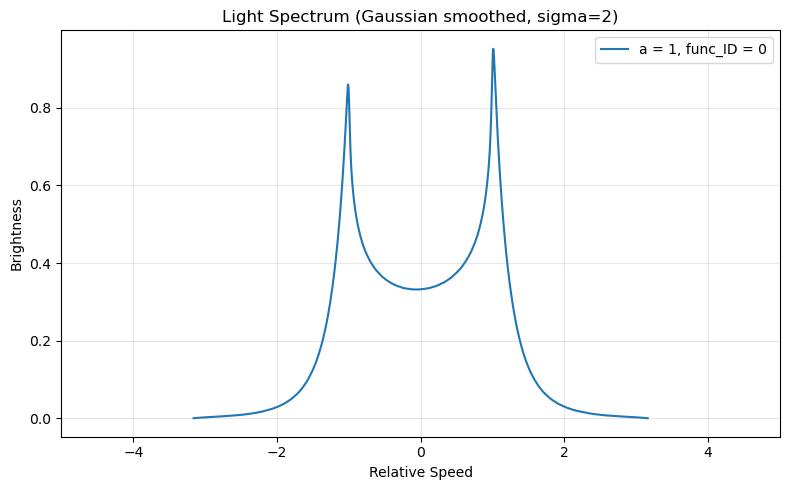

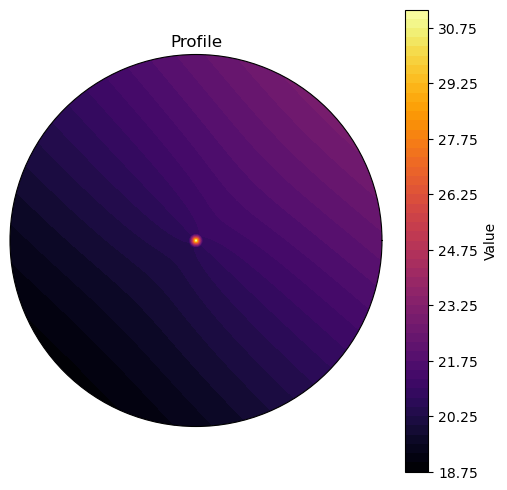

In [335]:
spots_params = [
    6,           # spot_1_max
    21,            # spot_r_cent_1
    4 * np.pi/16,   # spot_theta_1
    7,           # spot_rad_1
    2,            # beta_1
    0.0,            # spot_2_max
    0.8,            # spot_r_cent_2
    -8 * np.pi/16,  # spot_theta_2
    0.03,           # spot_rad_2
    0.5             # beta_2
]
r_vals, theta_vals, intens_vals, vel_vals, area_intens = get_grids(
    inv_power_2_spots, radial_spacing="linear",
    other_intens_params= spots_params
)

fname = plot_spectrum_list(
    a_vals=1, intens_funcs=inv_power_2_spots,
    other_intens_params=spots_params, sigma=2, save_info=True
)

plot_polar_profile(r_vals, theta_vals, intens_vals, save_info=True, fname=fname)

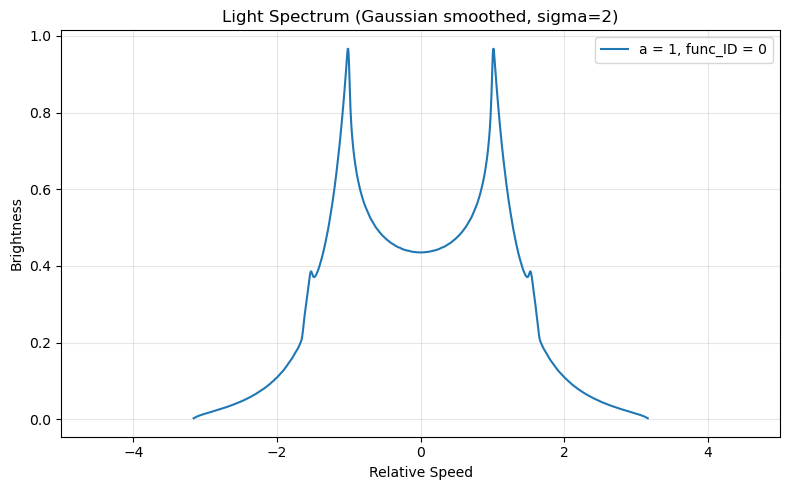

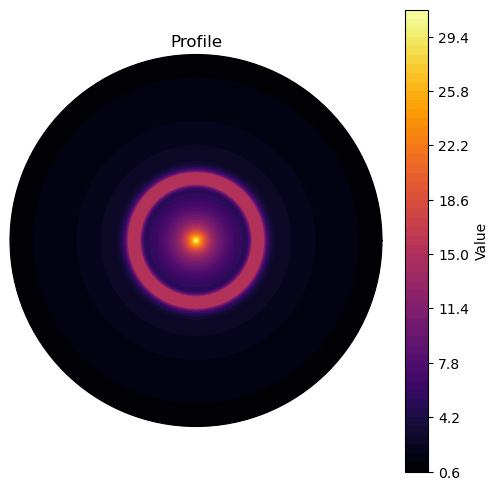

In [312]:
ring_params = [
    0.5,            # ring_max
    0.4,            # ring_r
    0.05,           # ring_width
    1.5             # beta
]
r_vals, theta_vals, intens_vals, vel_vals, area_intens = get_grids(
    inv_power_1_ring, radial_spacing="linear",
    other_intens_params= ring_params
)


fname = plot_spectrum_list(
    a_vals=1, intens_funcs=inv_power_1_ring,
    other_intens_params=ring_params, sigma=2,
    save_info=True
)

plot_polar_profile(
    r_vals, theta_vals, intens_vals,
    save_info=True, fname = fname
)

In [ ]:
# ----- OTHER INTENS FUNCTIONS -----


def weird_func1(
        r: np.ndarray[np.float64], 
        theta: np.ndarray[np.float64],
        a: float = 1.5
) -> np.ndarray[np.float64]:
    f = lambda r: -4 * (r - 1.5) * ((r - 0.5) ** 2) * (r + 0.5)
    g = lambda r, func, a: func(2*r - 0.5) ** a
    return g(r, f, a)

def weird_func2(
        r: np.ndarray[np.float64], 
        theta: np.ndarray[np.float64],
        a: float = 1.5
) -> np.ndarray[np.float64]:
    return (3 / (2*r) - 54 * (2/3 * r - 0.5)**2)

def weird_func3(
        r: np.ndarray[np.float64], 
        theta: np.ndarray[np.float64],
        a: float = 1.5
) -> np.ndarray[np.float64]:
    r_mid = (R_MAX + R_MIN) / 2
    return get_intens(r, theta, a) + get_intens(r-r_mid, theta, a) / 42

def weird_func4(
        r: np.ndarray[np.float64], 
        theta: np.ndarray[np.float64],
        a: float = 1.5
) -> np.ndarray[np.float64]:
    r_mid = (R_MAX + R_MIN) / 2
    bump1 = (1.5 - (21 * (r - r_mid))**2)
    bump2 = (1.5 - (21 * (r - 1.5*r_mid))**2)
    mask1 = np.full_like(r, bump1 > 1, dtype = np.bool)
    mask2 = np.full_like(r, bump2 > 1, dtype = np.bool)
    res = r**(-a)
#     res[mask1] *= bump1[mask1]
    res[mask2] *= 1.5 * bump2[mask2]
    return res

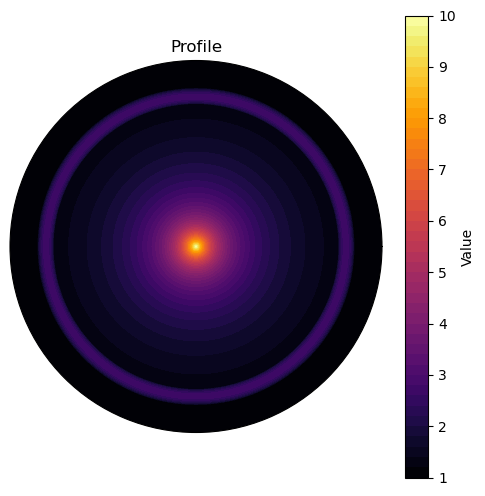

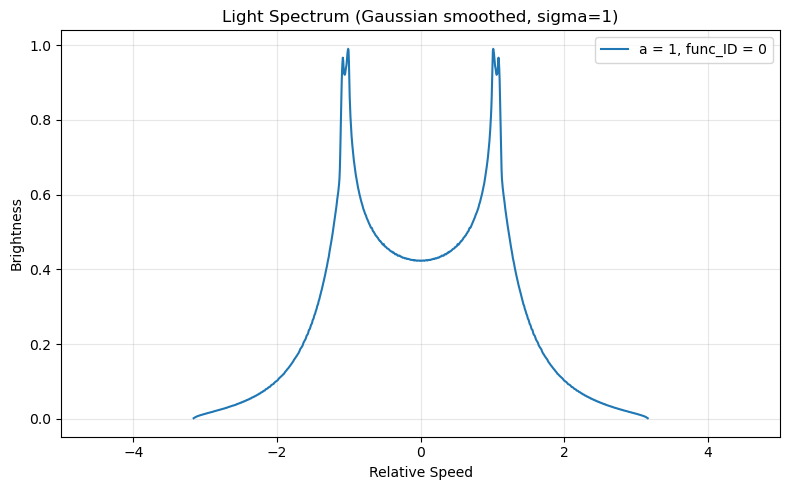

In [ ]:
# ----- TESTING -----


intens_funcs = [
    lambda r, theta, a: r * np.cos(theta),
    weird_func1,
    weird_func2,
    weird_func3,
    weird_func4
]


# r_vals, theta_vals, intens_vals, vel_vals, area_intens = get_grids(intens_funcs[0], a=0.3)
# plot_polar_profile(r_vals, theta_vals, intens_vals) #, colour_contrast_style="nonneg")

# r_vals, theta_vals, intens_vals, vel_vals, area_intens = get_grids(weird_func1, a=0.3)
# plot_polar_profile(r_vals, theta_vals, intens_vals) #, colour_contrast_style="nonneg")

# r_vals, theta_vals, intens_vals, vel_vals, area_intens = get_grids(weird_func2, a=1)
# plot_polar_profile(r_vals, theta_vals, intens_vals) #, colour_contrast_style="nonneg")

# r_vals, theta_vals, intens_vals, vel_vals, area_intens = get_grids(weird_func3, a=1)
# plot_polar_profile(r_vals, theta_vals, intens_vals) #, colour_contrast_style="nonneg")

r_vals, theta_vals, intens_vals, vel_vals, area_intens = get_grids(weird_func4, a=1)
plot_polar_profile(r_vals, theta_vals, intens_vals) #, colour_contrast_style="nonneg")

plot_spectrum_list(a_vals=1, intens_funcs=weird_func4, sigma=1)

In [ ]:
def ring_func(r, theta, a=1.5, r0=2.0, width=0.1, amp=3.0):
    return get_intens(r, theta, a) + amp * np.exp(-((r - r0)**2) / (2*width**2))

def companion_light(r, theta, r_star=5.0, theta_star=0.0, amp=200.0):
    dx = r*np.cos(theta) - r_star*np.cos(theta_star)
    dy = r*np.sin(theta) - r_star*np.sin(theta_star)
    dist = np.sqrt(dx**2 + dy**2)
    return amp / (dist**2 + EPS)

def disk_plus_companion(r, theta, a=1.5, **kwargs):
    return get_intens(r, theta, a) + companion_light(r, theta, **kwargs)

def eccentric_disk(r, theta, a=1.5, k=0.2):
    r_eff = r * (1 + k*np.cos(theta))  # squashes disk
    return r_eff**(-a)

def hotspot(r, theta, a=1.5, r0=2.0, theta0=1.0, width=0.1, amp=40.0):
    dr = (r - r0)**2
    dtheta = (theta - theta0)**2
    return get_intens(r, theta, a) + amp*np.exp(-(dr + dtheta)/(2*width**2))

def multi_spots(r, theta, a=1.5, n_spots=10, width=0.055, amp=80.0, seed=0):
    rng = np.random.default_rng(seed)
    r_spots = rng.uniform(1.0, 3.0, n_spots)
    theta_spots = rng.uniform(0, 2*np.pi, n_spots)
    base = get_intens(r, theta, a)
    for r0, t0 in zip(r_spots, theta_spots):
        dr = (r - r0)**2
        dtheta = (theta - t0)**2
        base += amp*np.exp(-(dr + dtheta)/(2*width**2))
    return base

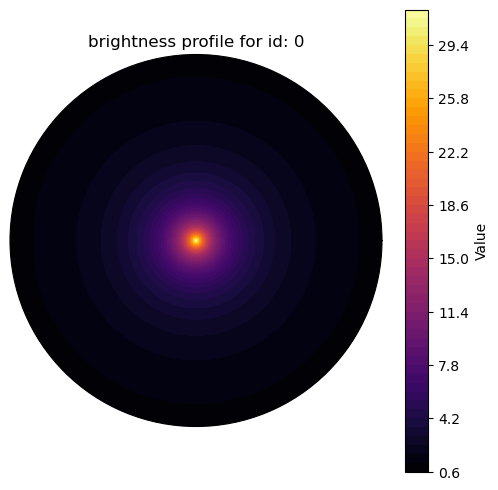

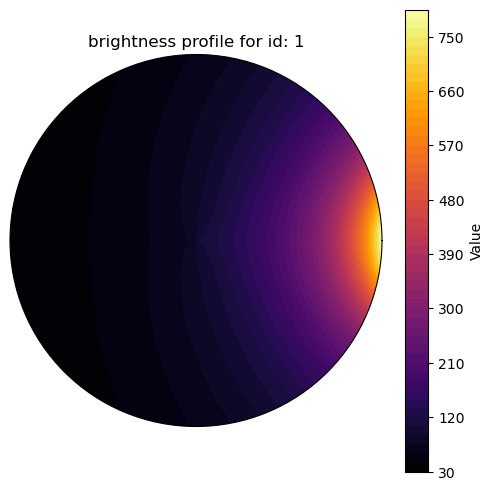

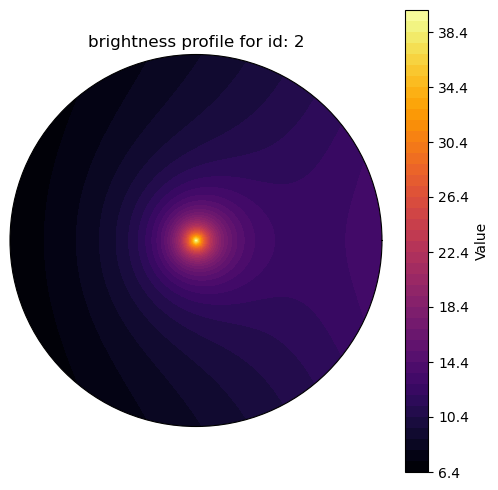

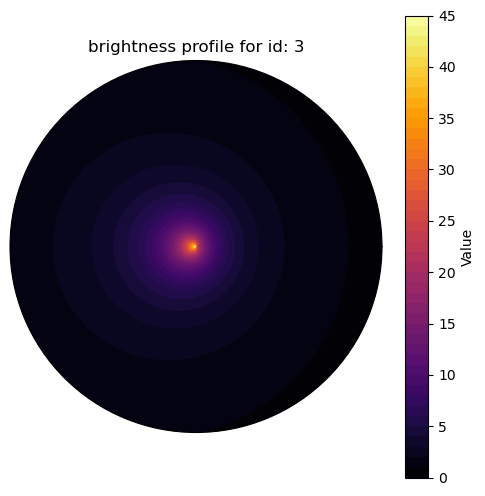

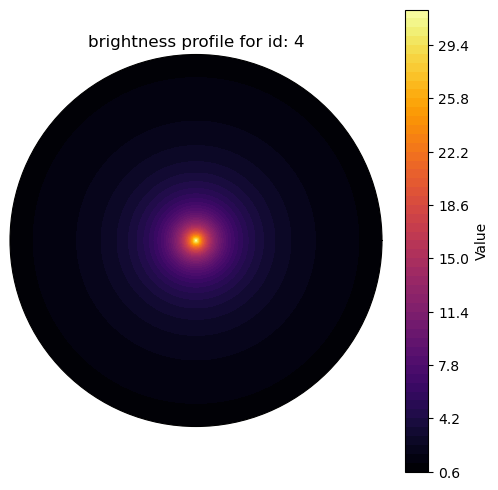

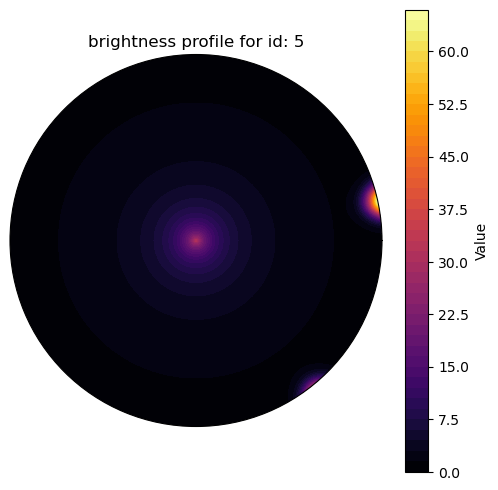

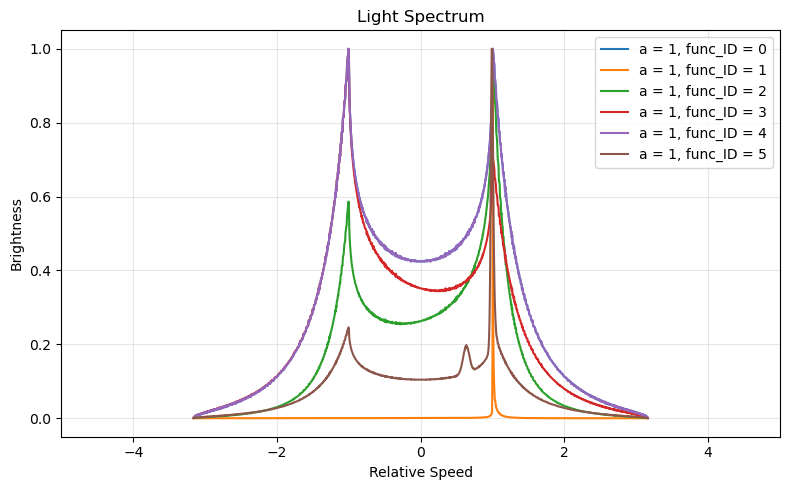

In [ ]:
# ----- TESTING -----

chat_intens_funcs = [
    ring_func,
    companion_light,
    disk_plus_companion,
    eccentric_disk,
    hotspot,
    multi_spots
]

for i in range(len(chat_intens_funcs)): 
    r_vals, theta_vals, intens_vals, vel_vals, area_intens = get_grids(chat_intens_funcs[i], a=1.5)
    plot_polar_profile(r_vals, theta_vals, intens_vals, title=f"brightness profile for id: {i}")

plot_spectrum_list(a_vals=1, intens_funcs=chat_intens_funcs) #, sigma=1)